# System Identification and Control Design

In [1]:
%load_ext autoreload
%autoreload 2
import px4tools.logsysid as logsysid
import pandas
import control
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Parameters

In [2]:
data, dt = logsysid.setup_data(pandas.read_csv('./sess052/log001.csv'))
d_tc = 1.0/125 # nyquist frequency of derivative in PID, (250 Hz/2)

# current gains that are able to stabilize the system
K_roll_guess = np.matrix([[0.01, 0.01, 0.001]]).T
K_pitch_guess = np.matrix([[0.01, 0.01, 0.001]]).T

# Roll Axis

In [3]:
y_roll = data.ATT_RollRate.diff()/dt
# remove bias
y_roll_bias = y_roll.rolling(100).mean()
y_roll -= y_roll_bias
u_roll = pandas.Series(data.ATTC_Roll)
u_roll_bias = u_roll.rolling(100).mean()
u_roll -= u_roll_bias

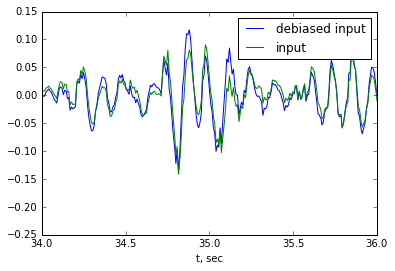

In [4]:
u_roll.plot(label='debiased input')
data.ATTC_Roll.plot(label='input')
gca().set_xlim([34, 36])
legend()
xlabel('t, sec')

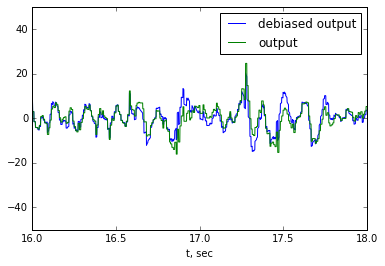

In [5]:
y_roll.plot(label='debiased output')
(data.ATT_RollRate.diff()/dt).plot(label='output')
gca().set_xlim([16, 18])
legend()
xlabel('t, sec')

In [6]:
G_ol_roll, delay_roll, k_roll = logsysid.attitude_sysid(y_roll, u_roll)

solving for plant model done


In [7]:
G_ol_roll, delay_roll, k_roll

(
 -235.8 s + 1.15e+04
 -------------------
    s^2 + 48.78 s, 0.040999999110733834, 235.81793957595264)

(11, 12)

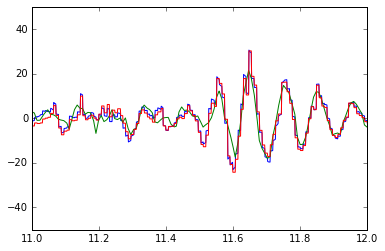

In [8]:
logsysid.plot_delay_and_gain_fit(k_roll, delay_roll, y_roll, u_roll)
(data.ATT_RollRate.diff()/dt).plot()
gca().set_xlim([11, 12])

In [9]:
K_roll, G_ol_roll_rate, G_cl_roll_rate = logsysid.attitude_rate_design(
    G_ol_roll, K_roll_guess, d_tc)
K_roll

optimizing controller
cost 0.000456853447456
jac [ 0.00051457 -0.00013615  0.00231304]
constraint [  8.53559367   8.53559367  40.47744052  40.47744052]
done


matrix([[ 0.07922699],
        [ 0.34604117],
        [ 0.00193611]])

(1.9651001055351975, 58.473264262102646, 20.953685617810414, 92.165733886202219)


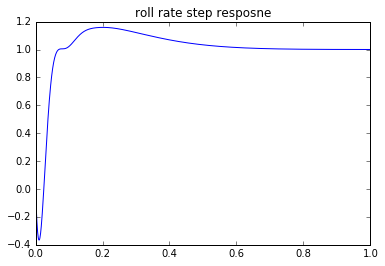

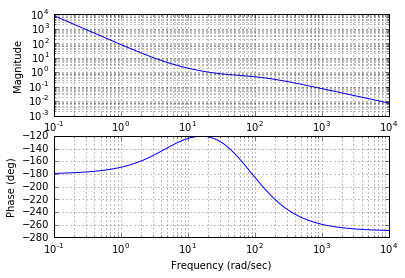

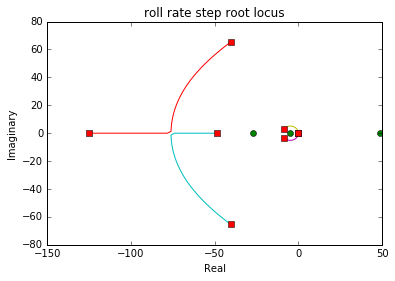

In [10]:
logsysid.plot_attitude_rate_design('roll', G_ol_roll_rate, G_cl_roll_rate)

# Pitch Axis

In [11]:
y_pitch = data.ATT_PitchRate.diff()/dt
y_pitch -= y_pitch.rolling(100).mean()
u_pitch = pandas.Series(data.ATTC_Pitch)
u_pitch -= u_pitch.rolling(100).mean()

In [12]:
G_ol_pitch, delay_pitch, k_pitch = logsysid.attitude_sysid(
    y_pitch, u_pitch)

solving for plant model done


In [13]:
G_ol_pitch, delay_pitch, k_pitch

(
 -190.9 s + 8678
 ---------------
  s^2 + 45.45 s, 0.044000000000206062, 190.91760846302586)

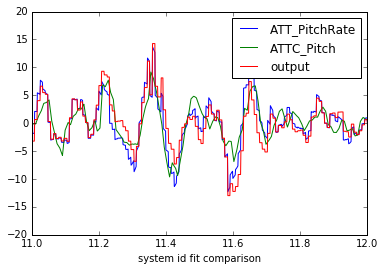

In [14]:
logsysid.plot_delay_and_gain_fit(k_pitch, delay_pitch, y_pitch, u_pitch)
(data.ATT_PitchRate.diff()/dt).plot(label='output')
gca().set_xlim([11, 12])
gca().set_ylim([-20, 20])
legend()
xlabel('t')
xlabel('system id fit comparison')

In [15]:
K_pitch, G_ol_pitch_rate, G_cl_pitch_rate = logsysid.attitude_rate_design(
    G_ol_pitch, K_pitch_guess, d_tc)
K_pitch

optimizing controller
cost 0.00121023931747
jac [ 0.00028726 -0.00029954  0.00015181]
constraint [  1.00900111  17.26764383  34.97439558  34.97439558]
done


matrix([[ 0.09913062],
        [ 0.0921994 ],
        [ 0.00265259]])

(1.7874188590102795, 62.01938113731488, 23.769554837781548, 89.891637202770994)


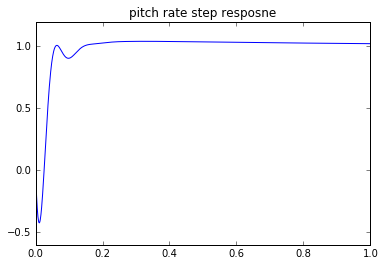

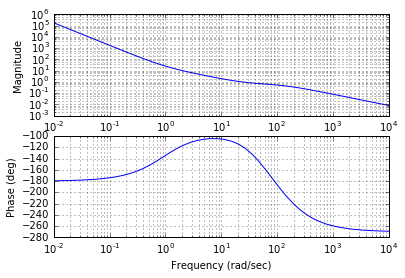

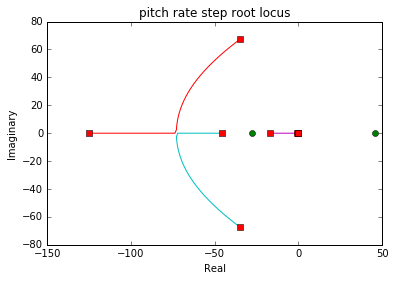

In [16]:
logsysid.plot_attitude_rate_design('pitch', G_ol_pitch_rate, G_cl_pitch_rate)

# Z Acceleration/ Thrust

In [89]:
t0 = 15
tf = 40
data_accz = data[t0:tf]
y_accz = -1*(pandas.Series(data_accz.IMU_AccZ))
# remove bias
y_accz_bias = y_accz.mean()
y_accz -= y_accz_bias
u_thrust = pandas.Series(data_accz.ATTC_Thrust)
u_thrust_bias = u_thrust.mean()
u_thrust -= u_thrust_bias

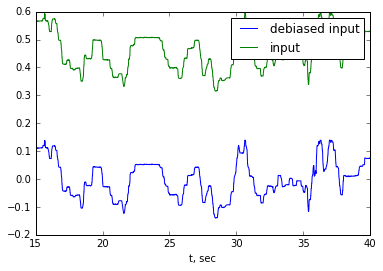

In [91]:
u_thrust.plot(label='debiased input')
data_accz.ATTC_Thrust.plot(label='input')
#gca().set_xlim([34, 36])
legend()
xlabel('t, sec')

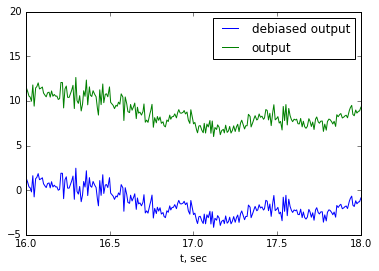

In [92]:
y_accz.plot(label='debiased output')
(-data.IMU_AccZ).plot(label='output')
gca().set_xlim([16, 18])
legend(loc='best')
xlabel('t, sec')

In [93]:
G_ol_accz, delay_accz, k_accz = logsysid.attitude_sysid(y_thrust, u_thrust)
G_ol_accz, delay_accz, k_accz

solving for plant model done


(
 -17.07 s + 3.414e+04
 --------------------
     s^2 + 2000 s, 0.001, 17.072229553315893)

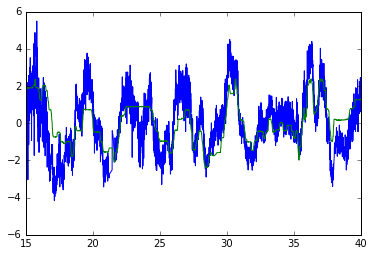

In [94]:
logsysid.plot_delay_and_gain_fit(k_accz, delay_accz, y_accz, u_thrust)

In [95]:
K_thrust, G_ol_accz, G_cl_accz = logsysid.attitude_rate_design(
    G_ol_accz, K_pitch_guess, d_tc)
K_thrust

optimizing controller
cost 0.00041854344503
jac [  1.03126315e-04  -3.73869706e-05  -7.85233048e-05]
constraint [    3.42404503    21.49394252   125.45370213  1949.86217278]
done


matrix([[  1.43228804e+00],
        [  4.21805945e+00],
        [  1.47039877e-04]])

(80.70566636460299, 81.911423929831045, 24.631161178730945, 1998.6694059379365)


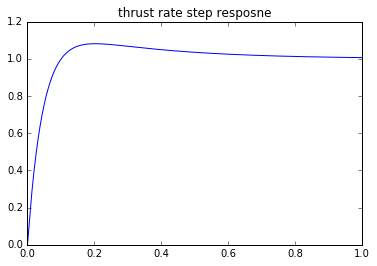

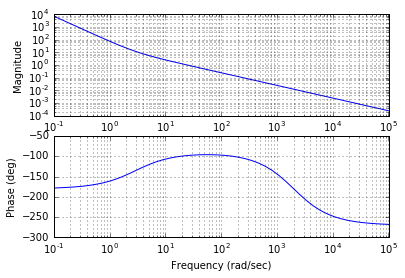

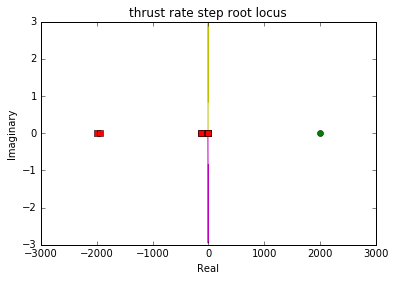

In [96]:
logsysid.plot_attitude_rate_design('thrust', G_ol_accz, G_cl_accz)